In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get update -qq && apt-get install -qq fluid-soundfont-gm build-essential libasound2-dev libjack-dev
!pip install -qU pyfluidsynth pretty_midi
!sudo apt-get install fluidsynth
!pip install torch-fidelity
!pip install pytorch-fid
!pip install pypianoroll
!pip install mir_eval
!pip install music21
!pip install triton

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fluid-soundfont-gm.
(Reading database ... 123614 files and directories currently installed.)
Preparing to unpack .../fluid-soundfont-gm_3.1-5.3_all.deb ...
Unpacking fluid-soundfont-gm (3.1-5.3) ...
Setting up fluid-soundfont-gm (3.1-5.3) ...
update-alternatives: using /usr/share/sounds/sf2/FluidR3_GM.sf2 to provide /usr/share/sounds/sf2/default-GM.sf2 (default-GM.sf2) in auto mode
update-alternatives: using /usr/share/sounds/sf2/FluidR3_GM.sf2 to provide /usr/share/sounds/sf3/default-GM.sf3 (default-GM.sf3) in auto mode
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 58.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.2 MB/s eta 0:00:00
   ━━

In [ ]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import mir_eval
import mir_eval.display
import IPython.display
import os
import sys
import json
import time
import torch
import random
import tables
import librosa
import pathlib
import pretty_midi
import pypianoroll
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
from torchvision.transforms import functional as TF
from torch.utils.data import DataLoader, TensorDataset, Dataset
from IPython.display import HTML, display
from pytorch_fid import fid_score
from datetime import datetime
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from google.colab import drive
import re

In [ ]:
cd "/content/drive/Shareddrives/Projects/PianorollGPT"

/content/drive/Shareddrives/Projects/PianorollGPT


In [24]:
from utils import get_random_song_ids, create_combined_pianorolls

combined_pianorolls_path = 'temp.pt'

file_paths = [
    # 'Lakh Piano Dataset/labels/tagtraum/id_list_Rock.txt',
    'Lakh Piano Dataset/labels/lastfm/id_list_favorites.txt',
    # 'Lakh Piano Dataset/labels/amg/id_list_Pop_Rock.txt'
]
random_song_ids = get_random_song_ids(file_paths, num_songs=1)
combined_pianorolls = create_combined_pianorolls(random_song_ids, combined_pianorolls_path)


/content/drive/Shareddrives/Projects/PianorollGPT/utils.py:88: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  cleansed_ids = pd.read_csv(os.path.join(root_dir, 'Lakh Piano Dataset', 'cleansed_ids.txt'), delimiter = '    ', header = None)


In [ ]:
from utils import get_random_song_ids, create_combined_pianorolls

combined_pianorolls_path = 'rock1000_acoustic_combined_pianorolls.pt'
# Check if the tensor file already exists
if os.path.exists(combined_pianorolls_path):
   # If the file exists, load the tensor
   combined_pianorolls = torch.load(combined_pianorolls_path)
else:
    file_paths = [
        # 'Lakh Piano Dataset/labels/tagtraum/id_list_Rock.txt',
        'Lakh Piano Dataset/labels/lastfm/id_list_rock.txt',
        # 'Lakh Piano Dataset/labels/amg/id_list_Pop_Rock.txt'
    ]
    random_song_ids = get_random_song_ids(file_paths, num_songs=1000)
    combined_pianorolls = create_combined_pianorolls(random_song_ids, combined_pianorolls_path)


/content/drive/MyDrive/PianorollGPT/utils.py:88: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  cleansed_ids = pd.read_csv(os.path.join(root_dir, 'Lakh Piano Dataset', 'cleansed_ids.txt'), delimiter = '    ', header = None)


In [ ]:
from utils import generate_dataset, max_tokens_in_line, average_tokens_per_line, view_dataset_sample
generate_dataset(combined_pianorolls)
max_tokens_in_line()
average_tokens_per_line()
view_dataset_sample()

Tokenized sequences have been saved to tagtraum_dataset.txt.
Maximum number of tokens in a single line: 49298
Line with maximum tokens: <SOT>  <beat>  <beat>  <beat>  <beat>  <beat>  <beat>  <beat>  <beat>  <beat>  <beat>  <beat>  <beat>  <beat>  <beat>  <beat>  <beat> D35 D61 D70 E65 <beat> D70 <beat> D42 D63 D70 E63 <beat> D63 D70 <beat> D35 D40 D70 E65 <beat> D70 <beat> D42 D61 D70 E63 <beat> D61 D70 <beat> D35 D61 D70 E65 <beat> D70 E65 <beat> D42 D63 D70 E63 <beat> D63 D70 E65 <beat> D35 D40 D70 <beat> D70 <beat> D46 D61 D70 E63 <beat> D61 D70 E63 E64 <beat> D35 D42 D61 D70 E64 E65 <beat> D70 E65 <beat> D42 D63 D70 E63 <beat> D63 D70 <beat> D35 D40 D70 E65 <beat> D70 <beat> D42 D61 D70 E68 <beat> D61 D70 <beat> D35 D61 D70 E65 <beat> D70 E65 <beat> D42 D63 D70 E63 E65 <beat> D63 D70 E65 <beat> D35 D40 D70 <beat> D70 <beat> D46 D61 D70 E63 <beat> D61 D70 E63 E64 <beat> D35 D42 D61 D70 E64 E65 <beat> D70 <beat> D42 D63 D70 E63 <beat> D63 D70 <beat> D35 D40 D70 E65 <beat> D70 <beat> 

In [ ]:
# Open the input file in read mode and output file in write mode
with open('dataset.txt', 'r') as infile, open('cleaned_dataset.txt', 'w') as outfile:
    for line in infile:
        # Strip leading and trailing spaces and replace multiple spaces with a single space
        cleaned_line = ' '.join(line.strip().split())

        # Write the cleaned line to the output file
        outfile.write(cleaned_line + '\n')


In [ ]:
from utils import generate_dataset, max_tokens_in_line, average_tokens_per_line, view_dataset_sample

max_tokens_in_line('cleaned_dataset.txt')
average_tokens_per_line('cleaned_dataset.txt')
view_dataset_sample('cleaned_dataset.txt')

Maximum number of tokens in a single line: 49245
Line with maximum tokens: <SOT> <beat> <beat> <beat> <beat> <beat> <beat> <beat> <beat> <beat> <beat> <beat> <beat> <beat> <beat> <beat> <beat> <beat> <beat> <beat> <beat> D40 D50 <beat> <beat> <beat> <beat> D45 D47 <beat> <beat> <beat> <beat> D40 D50 <beat> <beat> D40 D50 <beat> <beat> D35 D42 <beat> <beat> D42 <beat> <beat> D42 <beat> <beat> D35 D42 <beat> <beat> D40 D42 <beat> <beat> D42 <beat> <beat> D42 Per74 Per86 <beat> Per74 Per86 <beat> D35 D42 Per74 Per86 <beat> Per74 Per86 <beat> D35 D42 Per74 Per86 <beat> Per74 Per86 <beat> D42 Per74 Per86 <beat> Per74 Per86 <beat> D35 D42 Per74 Per86 <beat> Per74 Per86 <beat> D42 Per74 Per86 <beat> Per74 Per86 <beat> D40 D42 Per74 Per86 <beat> <beat> D42 <beat> <beat> D42 <beat> <beat> D40 D42 <beat> <beat> D35 D42 <beat> <beat> D42 <beat> <beat> D42 <beat> <beat> D35 D42 <beat> <beat> D40 D42 <beat> <beat> D42 <beat> <beat> D42 <beat> <beat> D35 D42 <beat> Per74 Per86 <beat> D35 D42 Per74 P

In [26]:
pianoroll_numpy = combined_pianorolls[0].detach().cpu().numpy()

# Define the program numbers for the tracks
programs = {
 'Drums': 0,
 'Piano': 0,
 'Chromatic Percussion': 8,
 'Organ': 16,
 'Guitar': 24,
 'Bass': 32,
 'Strings': 40,
 'Ensemble': 48,
 'Brass': 56,
 'Reed': 64,
 'Pipe': 72,
 'Synth Lead': 80,
 'Synth Pad': 88,
 'Synth Effects': 96,
 'Ethnic': 104,
 'Percussive': 112,
 'Sound Effects': 120
}

# Define the track names in the same order as they were stacked
track_names = [
    'Drums', 'Piano', 'Chromatic Percussion', 'Organ', 'Guitar', 'Bass',
    'Strings', 'Ensemble', 'Brass', 'Reed', 'Pipe', 'Synth Lead', 'Synth Pad',
    'Synth Effects', 'Ethnic', 'Percussive', 'Sound Effects'
]

# Create the tracks
tracks = []
for i, track_name in enumerate(track_names):
    is_drum = track_name == 'Drums'
    track = pypianoroll.StandardTrack(
        name=track_name,
        program=programs[track_name],
        is_drum=is_drum,
        pianoroll=pianoroll_numpy[i]
    )
    tracks.append(track)

# Create the multitrack object
original_multitrack = pypianoroll.Multitrack(name='Original', resolution=4, tracks=tracks)

In [27]:
original_pm = pypianoroll.to_pretty_midi(original_multitrack)
original_midi_audio = original_pm.fluidsynth()
IPython.display.Audio(original_midi_audio, rate=44100)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from data_loader import PianoRollDataLoader
from tokenizer import PianoRollTokenizer
tokenizer = PianoRollTokenizer(dataset_path="cleaned_dataset.txt")
train_loader = PianoRollDataLoader(dataset_path='cleaned_dataset.txt', B=64, T=1024)
batch_x, batch_y = train_loader.next_batch()

for i in range(len(train_loader.song_tokens[0])):
    if '<PAD>' in tokenizer.decode(batch_y[0].tolist()):
        print(tokenizer.decode(batch_y[0].tolist()))
        break
    else:
        batch_x, batch_y = train_loader.next_batch()

  G60   G65   G69   B36   E60   E65   E69   <beat>   P72   P76   P79   G65   B36   E60   E65   E69   <beat>   D35   D38   D49   P72   P76   P77   P79   P81   G60   G65   G69   G72   B29   E60   E65   E69   <beat>   P72   P77   P81   G60   G65   G69   G72   B29   E60   E65   E69   <beat>   P72   P77   P81   G60   G65   G69   G72   B29   E60   E65   E69   <beat>   P72   P77   P81   G60   G65   G69   G72   B29   E60   E65   E69   <beat>   P72   P77   P81   G60   G65   G69   G72   B29   E60   E65   E69   <beat>   P72   P77   P81   G60   G65   G69   G72   B29   E60   E65   E69   <beat>   P72   P77   P81   G60   G65   G69   G72   B29   E60   E65   E69   <beat>   P72   P77   P81   G60   G65   G69   G72   B29   E60   E65   E69   <beat>   P72   P77   P81   G60   G65   G69   G72   E60   E65   E69   <beat>   P72   P77   P81   G60   G65   G69   G72   E60   E65   <beat>   P72   P77   P81   G60   G65   G69   G72   <beat>   P72   P77   P81   <beat>   P72   P77   P81   <beat>   P72   P77   P81   <beat

In [ ]:
T = 1024
print(train_loader.song_tokens[0].shape)

torch.Size([25967])


In [ ]:
from dataclasses import dataclass
from data_loader import PianoRollDataLoader
from model import GPT
import math

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"using device: {device}")

@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 2048
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768

total_batch_size = 24576
B = 12
T = 1024
assert total_batch_size % (B * T) == 0, "make sure the total batch size is divisible by B*T"
grad_accum_steps = total_batch_size // (B*T)

print(f"Total desired batch size {total_batch_size}")
print(f"=> Calculated gradient accumulation steps: {grad_accum_steps}")


train_loader = PianoRollDataLoader(dataset_path="cleaned_dataset.txt",B=B, T=T)

model = GPT(GPTConfig())
model.to(device)
model = torch.compile(model)
model.load_state_dict(torch.load("model_checkpoint_step_15000.pth"))

max_lr = 1.5e-5
# min_lr = max_lr * 0.1
min_lr = 1e-5
warmup_steps = 10
max_steps = 5000
def get_lr(it):
    if it < warmup_steps:
        return max_lr * (it+1)/warmup_steps
    if it >= max_steps:
        return min_lr

    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0<=decay_ratio<1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff*(max_lr - min_lr)
# optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, betas=(0.9, 0.95), eps=1e-8)
optimizer = model.configure_optimizer(weight_decay=0.1, learning_rate=3e-4, device=device)

using device: cuda
Total desired batch size 24576
=> Calculated gradient accumulation steps: 2


<ipython-input-3-c46d5eff3a1d>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_checkpoint_step_15000.pth"))


Num of decayed parameter tensors: 50, with 87,293,952 parameters
Num of non-decayed parameter tensors: 98, with 121,344 parameters
Using fused AdamW: True


In [ ]:
import time
import torch
import matplotlib.pyplot as plt

# Variables to store loss for plotting
losses = []

# Training loop
for step in range(50000):
    t0 = time.time()
    optimizer.zero_grad()
    loss_accum = 0.0
    for micro_step in range(grad_accum_steps):
        x, y = train_loader.next_batch()
        x = x.to(device)
        y = y.to(device)
        logits, loss = model(x, y)
        loss = loss / grad_accum_steps
        loss_accum += loss.detach()
        loss.backward()
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    lr = get_lr(step)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    optimizer.step()
    torch.cuda.synchronize()
    t1 = time.time()
    dt = (t1 - t0) * 1000
    tokens_per_sec = (train_loader.B * train_loader.T * grad_accum_steps) / (t1 - t0)

    # Store the accumulated loss for plotting
    losses.append(loss_accum.item())

    print(f"Step {step:4d} | loss: {loss_accum.item():.6f} | lr: {lr:.4e} | norm: {norm:.4f} | dt: {dt:.2f}ms | tok/sec: {tokens_per_sec:.2f}")

    # Save model checkpoint every 5000 steps
    if (step + 1) % 5000 == 0:
        checkpoint_filename = f"model_checkpoint_step_{step + 1}.pth"
        torch.save(model.state_dict(), checkpoint_filename)
        print(f"Checkpoint saved at step {step + 1}: {checkpoint_filename}")

# Save final model
torch.save(model.state_dict(), "model_state_dict.pth")
print("Final model saved.")

Step    0 | loss: 0.956915 | lr: 1.5000e-06 | norm: 1.5226 | dt: 35351.09ms | tok/sec: 695.20
Step    1 | loss: 0.458516 | lr: 3.0000e-06 | norm: 1.4512 | dt: 4177.51ms | tok/sec: 5882.93
Step    2 | loss: 0.505296 | lr: 4.5000e-06 | norm: 1.6417 | dt: 4206.21ms | tok/sec: 5842.79
Step    3 | loss: 0.449027 | lr: 6.0000e-06 | norm: 1.4210 | dt: 4220.04ms | tok/sec: 5823.64
Step    4 | loss: 0.476183 | lr: 7.5000e-06 | norm: 0.8489 | dt: 4257.77ms | tok/sec: 5772.04
Step    5 | loss: 0.572749 | lr: 9.0000e-06 | norm: 1.0950 | dt: 4283.69ms | tok/sec: 5737.11
Step    6 | loss: 0.635604 | lr: 1.0500e-05 | norm: 1.3864 | dt: 4308.25ms | tok/sec: 5704.41
Step    7 | loss: 0.680412 | lr: 1.2000e-05 | norm: 0.9553 | dt: 4340.67ms | tok/sec: 5661.80
Step    8 | loss: 0.563718 | lr: 1.3500e-05 | norm: 2.0377 | dt: 4376.21ms | tok/sec: 5615.82
Step    9 | loss: 0.555601 | lr: 1.5000e-05 | norm: 1.3471 | dt: 4396.11ms | tok/sec: 5590.40
Step   10 | loss: 0.498497 | lr: 1.5000e-05 | norm: 1.5123 |

KeyboardInterrupt: 

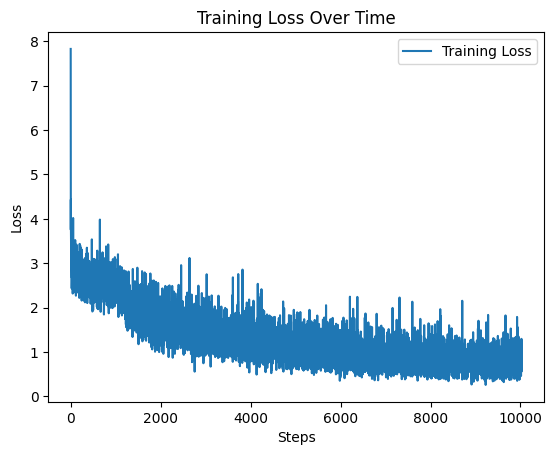

In [ ]:
# Plot the loss over time
plt.plot(range(len(losses)), losses, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

In [ ]:
#Use this to load the model
model = GPT(GPTConfig())
model.to(device)
model = torch.compile(model)

model.load_state_dict(torch.load("model_checkpoint_step_15000.pth"))
model.eval()

<ipython-input-5-4d0c0e3bfbe2>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_checkpoint_step_15000.pth"))


OptimizedModule(
  (_orig_mod): GPT(
    (transformer): ModuleDict(
      (wte): Embedding(2048, 768)
      (wpe): Embedding(1024, 768)
      (h): ModuleList(
        (0-11): 12 x Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): CausalSelfAttention(
            (c_attn): Linear(in_features=768, out_features=2304, bias=True)
            (c_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): MLP(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='tanh')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Linear(in_features=768, out_features=2048, bias=False)
  )
)

In [ ]:
from tokenizer import PianoRollTokenizer
# Create the tokenizer
tokenizer = PianoRollTokenizer(dataset_path="cleaned_dataset.txt")

In [ ]:
sot_token_id = tokenizer.token_to_id['<SOT>']
context = torch.tensor([[sot_token_id]], dtype=torch.long, device=device)
generated_output = model.generate(context, tokenizer, max_new_tokens=2048, temperature=0.9)
# predicted_tokens = tokenizer.decode(model.generate(context, tokenizer, max_new_tokens=10240)[0].tolist())

In [ ]:
generated_output[0].shape

torch.Size([2049])

In [ ]:
predicted_tokens = tokenizer.decode(generated_output[0].tolist())

In [ ]:
predicted_tokens = predicted_tokens.replace('<SOT>', '').replace('<PAD>', '').replace('<EOT>', '').strip()
predicted_tokens=predicted_tokens.split("<beat>")

In [ ]:
print(predicted_tokens)

In [ ]:
from utils import detokenize_sequence

num_time_steps = len(predicted_tokens)
predicted_tensor = detokenize_sequence(predicted_tokens, num_time_steps)


In [ ]:
a = predicted_tensor.contiguous()
a = a.view(1, -1, 128).squeeze(0).detach().cpu().numpy()

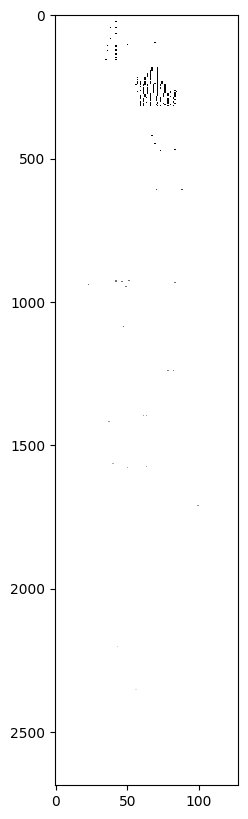

In [ ]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111)
ax.imshow(a, cmap = 'gray_r', interpolation = 'nearest')
ax.set_aspect(0.2)
plt.show()

In [ ]:
# Convert predictions into the multitrack pianoroll for the first song
pianoroll_numpy = predicted_tensor.detach().cpu().numpy()

# Define the program numbers for the tracks
programs = {
 'Drums': 0,
 'Piano': 0,
 'Chromatic Percussion': 8,
 'Organ': 16,
 'Guitar': 24,
 'Bass': 32,
 'Strings': 40,
 'Ensemble': 48,
 'Brass': 56,
 'Reed': 64,
 'Pipe': 72,
 'Synth Lead': 80,
 'Synth Pad': 88,
 'Synth Effects': 96,
 'Ethnic': 104,
 'Percussive': 112,
 'Sound Effects': 120
}

# Define the track names in the same order as they were stacked
track_names = [
    'Drums', 'Piano', 'Chromatic Percussion', 'Organ', 'Guitar',
    'Bass',
    # 'Strings', 'Ensemble', 'Brass', 'Reed', 'Pipe', 'Synth Lead', 'Synth Pad',
    # 'Synth Effects', 'Ethnic', 'Percussive', 'Sound Effects'
]

# Create the tracks
tracks = []
for i, track_name in enumerate(track_names):
    is_drum = track_name == 'Drums'
    track = pypianoroll.StandardTrack(
        name=track_name,
        program=programs[track_name],
        is_drum=is_drum,
        pianoroll=pianoroll_numpy[i]
    )
    tracks.append(track)

# Create the multitrack object
predicted_multitrack = pypianoroll.Multitrack(name='Original', resolution=4, tracks=tracks)

In [ ]:
predicted_pm = pypianoroll.to_pretty_midi(predicted_multitrack)
predicted_midi_audio = predicted_pm.fluidsynth()
IPython.display.Audio(predicted_midi_audio, rate=44100)

Output hidden; open in https://colab.research.google.com to view.